<a href="https://colab.research.google.com/github/Adrita2211/ML_Project/blob/object_detection/image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
pip install faiss-cpu

In [16]:
import cv2
import numpy as np
import faiss
import os
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from google.colab.patches import cv2_imshow
from google.colab import drive
import os

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load pre-trained model and remove top layers
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

In [5]:
# Compute embeddings using VGG16
def compute_embeddings(images):
    embeddings = []
    for img in images:
        img = cv2.resize(img, (224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        img_embedding = model.predict(img)
        embeddings.append(img_embedding.flatten())
    return np.array(embeddings)

In [6]:
def create_index(embeddings):
    d = embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(embeddings)
    return index

In [7]:
def load_images_from_folder(folder_path, target_size=(224, 224)):
    images = []
    image_paths = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            # Read image (modify based on your image types)
            img = cv2.imread(img_path)
            if img is not None:
                # Resize if needed
                img = cv2.resize(img, target_size)
                # Convert color space if needed (BGR to RGB)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                image_paths.append(img_path)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return np.array(images), image_paths

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
folder_path = '/content/sample_data'  # Update this path
images, image_paths = load_images_from_folder(folder_path)
embeddings = compute_embeddings(images)
index = create_index(embeddings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


In [10]:
def search_similar_images(index, query_embedding, top_k=1):
    D, I = index.search(query_embedding, top_k)
    return I

In [11]:
similar_images_indices = []

# Call search_similar_images for each query embedding in the array
for query_embedding in embeddings:
    # Reshape the query embedding if necessary (e.g., for FAISS, it expects 2D array)
    query_embedding = query_embedding.reshape(1, -1)
    I = search_similar_images(index, query_embedding, top_k=1)
    similar_images_indices.append(I)  # Append I to the list

In [12]:
print("Similar images indices:", similar_images_indices)
for idx in similar_images_indices[0].flatten(): # Flatten the array to get individual indices
    print(image_paths[idx])

Similar images indices: [array([[0]]), array([[1]]), array([[2]]), array([[3]]), array([[4]]), array([[5]]), array([[6]])]
/content/sample_data/img_7.png


In [13]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [19]:
from ultralytics import YOLO
model_yolo = YOLO('/content/sample_data/best.pt')

In [21]:
results = model_yolo.predict("/content/sample_data/test/test_img_fashion.png")
print(results[0].boxes.data.shape[0])


image 1/1 /content/sample_data/test/test_img_fashion.png: 480x640 1 Sweater, 1 T-Shirt, 1350.4ms
Speed: 11.1ms preprocess, 1350.4ms inference, 31.0ms postprocess per image at shape (1, 3, 480, 640)
2


In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [24]:
object_embeddings = []
object_classes = []  # Optional, if classification is performed
original_image = cv2.imread("/content/sample_data/test/test_img_fashion.png") # Load the image here

# Check if results contain any detections
if results[0].boxes.data.shape[0] > 0:  # Check if there are any detected bounding boxes
    for *xyxy, conf, cls in results[0].boxes.data: # Access bounding box data correctly
        x1, y1, x2, y2 = map(int, xyxy)
        cropped_object = original_image[y1:y2, x1:x2]

        # Preprocess for VGG16
        cropped_object = cv2.resize(cropped_object, (224, 224))
        cropped_object = image.img_to_array(cropped_object)
        cropped_object = np.expand_dims(cropped_object, axis=0)
        cropped_object = preprocess_input(cropped_object)

        # Generate embedding
        object_embedding = model.predict(cropped_object)
        object_embedding = object_embedding.flatten()
        object_embeddings.append(object_embedding)

        # Optional: Classification
        # predicted_class = model.predict(cropped_object)  # Assuming classification layer added
        # object_classes.append(predicted_class)
else:
    print("No objects detected in the image.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/content/sample_data/img_7.png


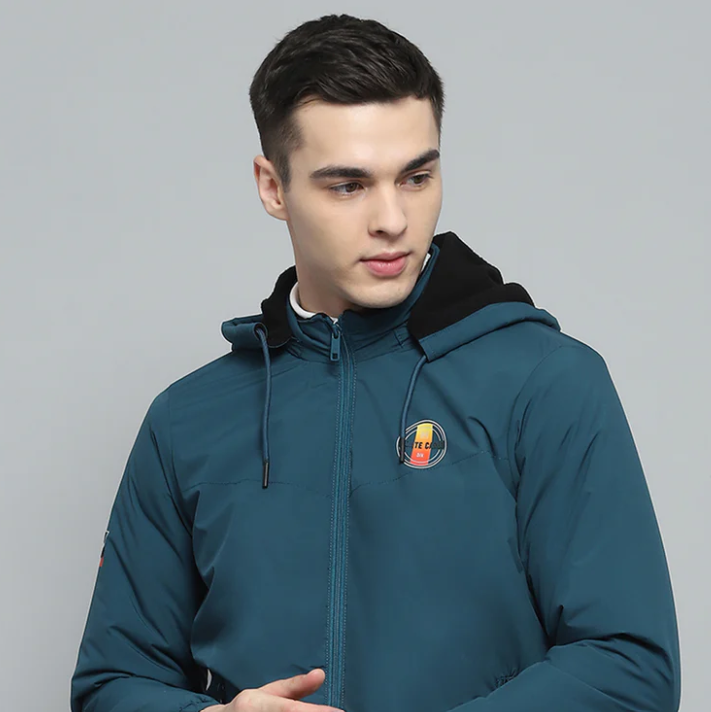

/content/sample_data/img_6.png


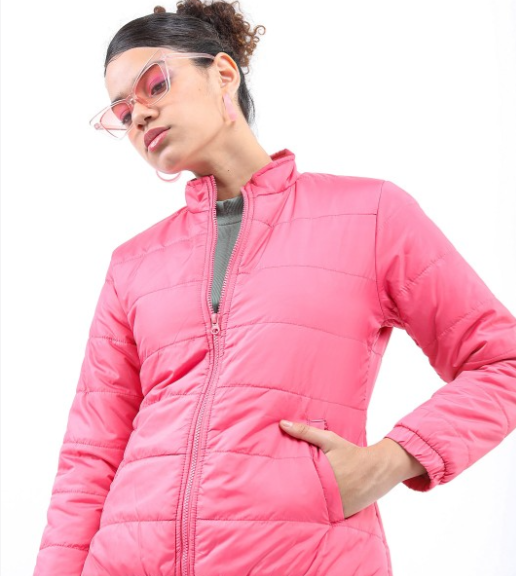

/content/sample_data/img_7.png


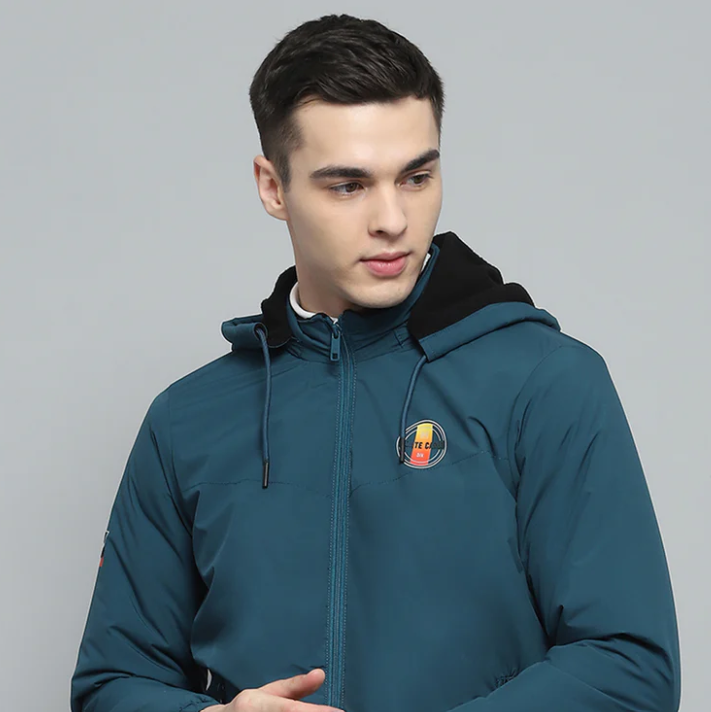

/content/sample_data/img_6.png


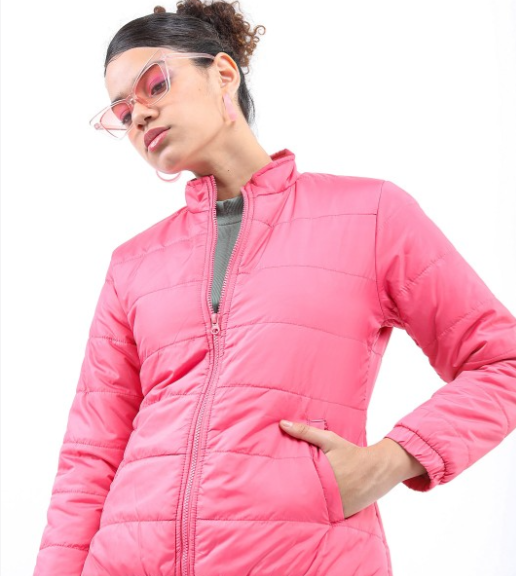

In [28]:
for query_embedding in object_embeddings:
       # Reshape for FAISS (if necessary)
       query_embedding = query_embedding.reshape(1, -1)

       # Perform the search
       similar_image_indices = search_similar_images(index, query_embedding, top_k=2) # Example: top_k=5 for 5 most similar

       # Process the results (e.g., display similar images)
       for idx in similar_image_indices.flatten():
           print(image_paths[idx]) # Prints paths of similar images
           similar_image=cv2.imread(image_paths[idx])
           cv2_imshow(similar_image)

In [29]:
# print("Query Image")
# # Load the image using cv2.imread before displaying
# query_image = cv2.imread("/content/sample_data/img_4.png")
# cv2_imshow(query_image)  # Display the loaded image
# cv2.waitKey(0)  # Wait for a key press to close the image

# # Iterate through the similar image indices and display
# for idx in similar_images_indices[0].flatten():  # Flatten the array to get individual indices
#     # Now idx is a single integer and can be used as an index
#     similar_image_path = image_paths[idx]
#     similar_image = cv2.imread(similar_image_path)
#     print("Most Similar Image")
#     cv2_imshow(similar_image)
#     cv2.waitKey(0)